In [1]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pathlib import Path
import os

In [ ]:
def load_video(video_path):
 
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Video Properties:")
    print(f"Frame Count: {frame_count}")
    print(f"FPS: {fps}")
    print(f"Resolution: {frame_width}x{frame_height}")
    
    return cap, frame_count, fps, frame_width, frame_height

video_path = r"C:\Users\91936\Downloads\videoplayback.mp4"
cap, frame_count, fps, width, height = load_video(video_path)

Video Properties:
Frame Count: 418
FPS: 23
Resolution: 640x320


In [3]:
def extract_frames(cap, sample_rate=1):

    frames = []
    frame_indices = []
    count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if count % sample_rate == 0:
            frames.append(frame)
            frame_indices.append(count)
            
        count += 1
    
    return frames, frame_indices

# Extract frames
frames, frame_indices = extract_frames(cap, sample_rate=1)
print(f"Extracted {len(frames)} frames")

Extracted 418 frames


In [4]:
def segment_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Combine threshold and edges
    mask = cv2.bitwise_or(thresh, edges)
    
    # Apply mask to original frame
    segmented = cv2.bitwise_and(frame, frame, mask=mask)
    
    return segmented, mask

def track_segments(frames):

    segmented_frames = []
    motion_history = np.zeros_like(frames[0][:,:,0], dtype=np.float32)
    
    for i, frame in enumerate(frames):
        # Segment current frame
        segmented, mask = segment_frame(frame)
        segmented_frames.append(segmented)
        
        # Update motion history
        if i > 0:
            frame_diff = cv2.absdiff(frames[i], frames[i-1])
            motion_mask = cv2.threshold(cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY), 
                                     30, 1, cv2.THRESH_BINARY)[1]
            motion_history = cv2.motempl.updateMotionHistory(
                motion_mask, motion_history, i, 0.5
            )
    
    return segmented_frames, motion_history


segmented_frames, motion_history = track_segments(frames)

In [5]:
def detect_scene_cuts(frames, threshold=30):

    differences = []
    
    for i in range(1, len(frames)):
        
        prev_gray = cv2.cvtColor(frames[i-1], cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        
        # Calculate histogram difference
        prev_hist = cv2.calcHist([prev_gray], [0], None, [256], [0, 256])
        curr_hist = cv2.calcHist([curr_gray], [0], None, [256], [0, 256])
        diff = cv2.compareHist(prev_hist, curr_hist, cv2.HISTCMP_CHISQR)
        differences.append(diff)
    
    # Detect peaks in differences
    peaks, _ = find_peaks(differences, height=threshold, distance=10)
    
    return peaks, differences


cut_indices, frame_differences = detect_scene_cuts(frames)
print(f"Detected {len(cut_indices)} scene cuts")

Detected 29 scene cuts


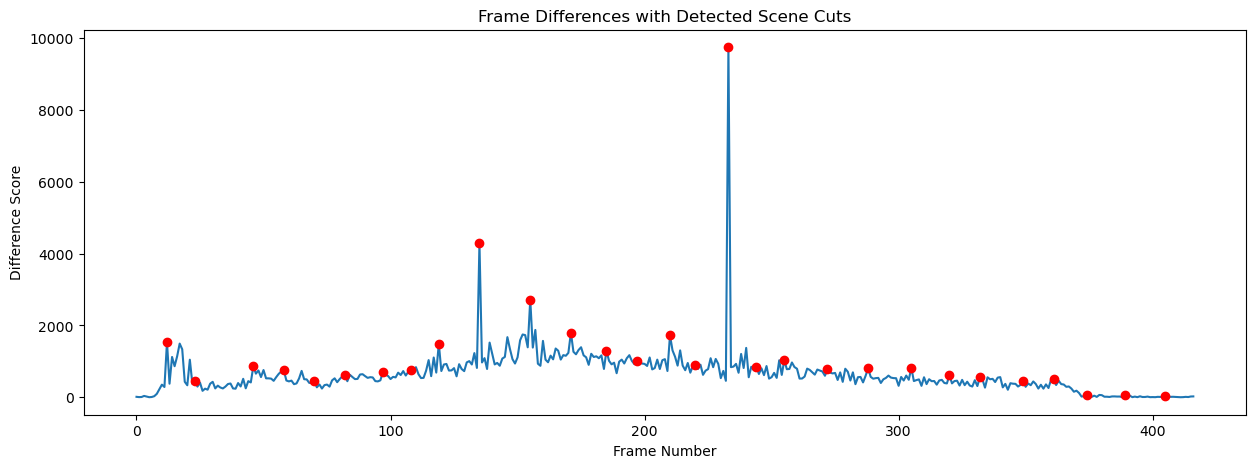

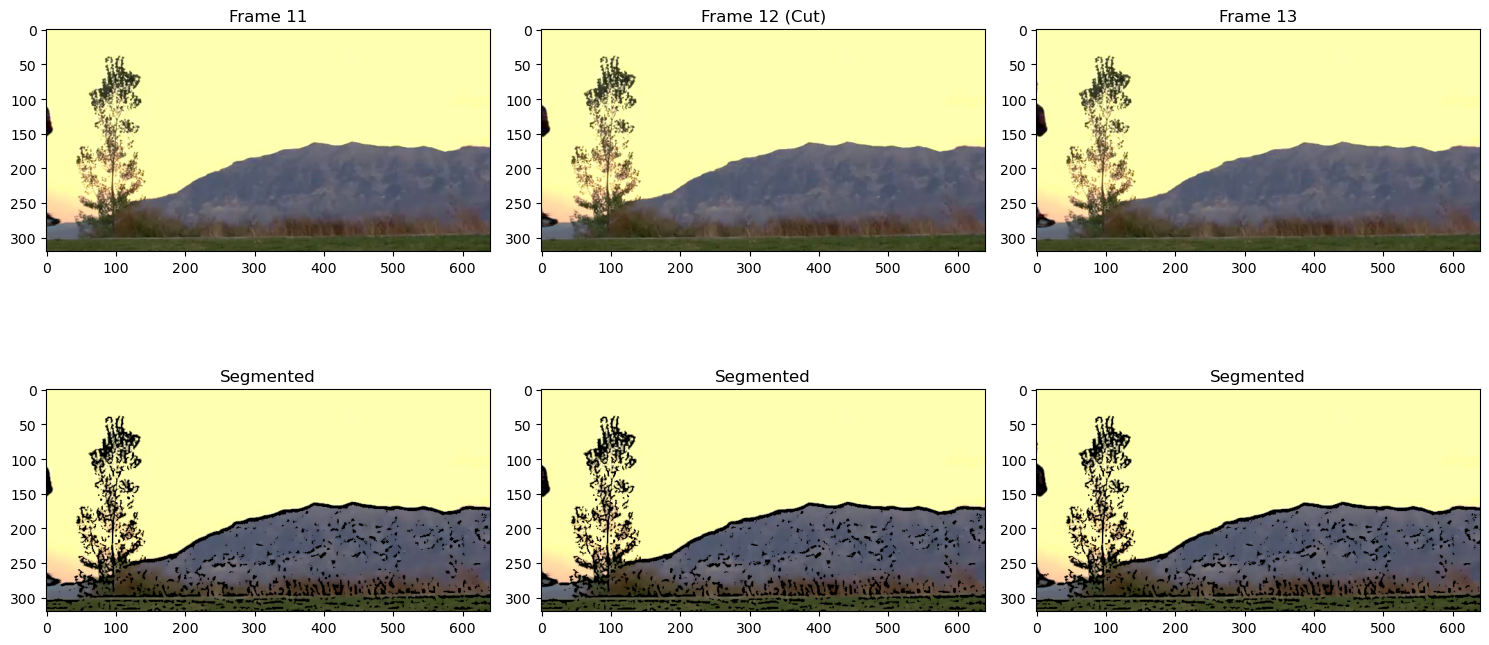

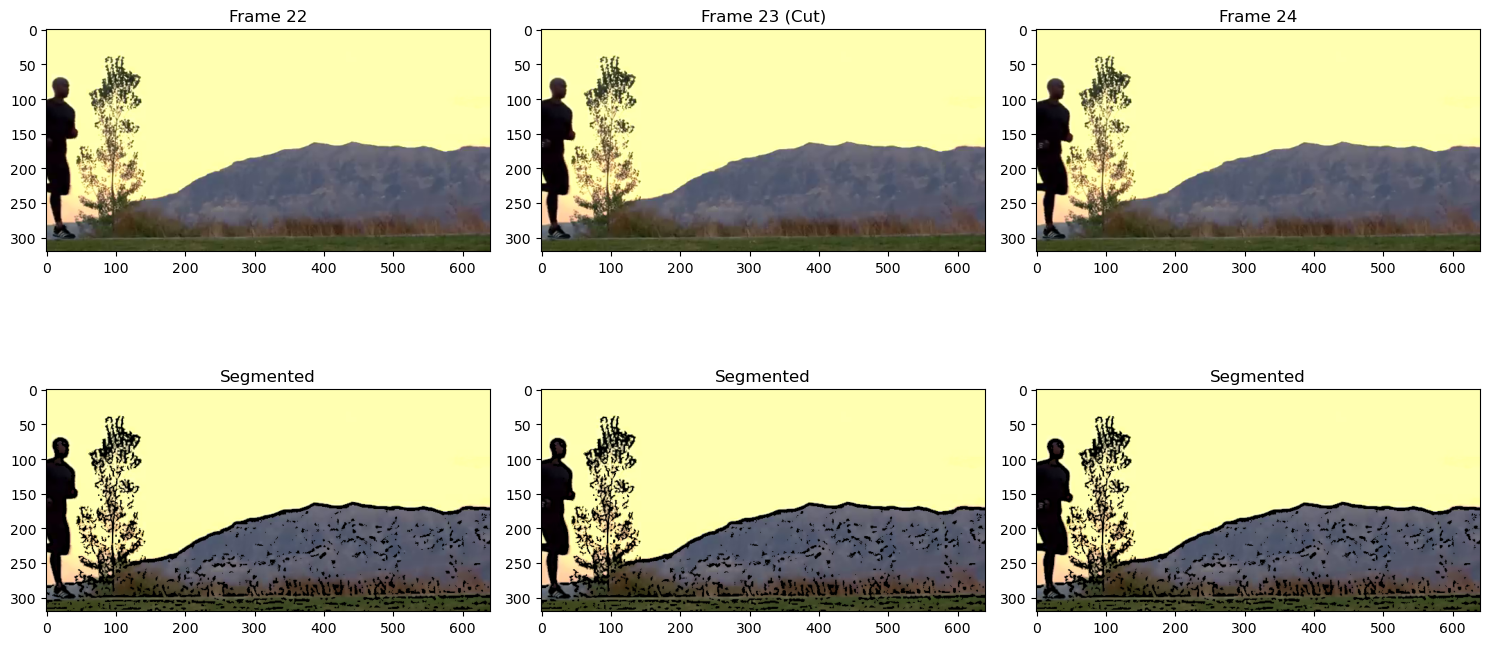

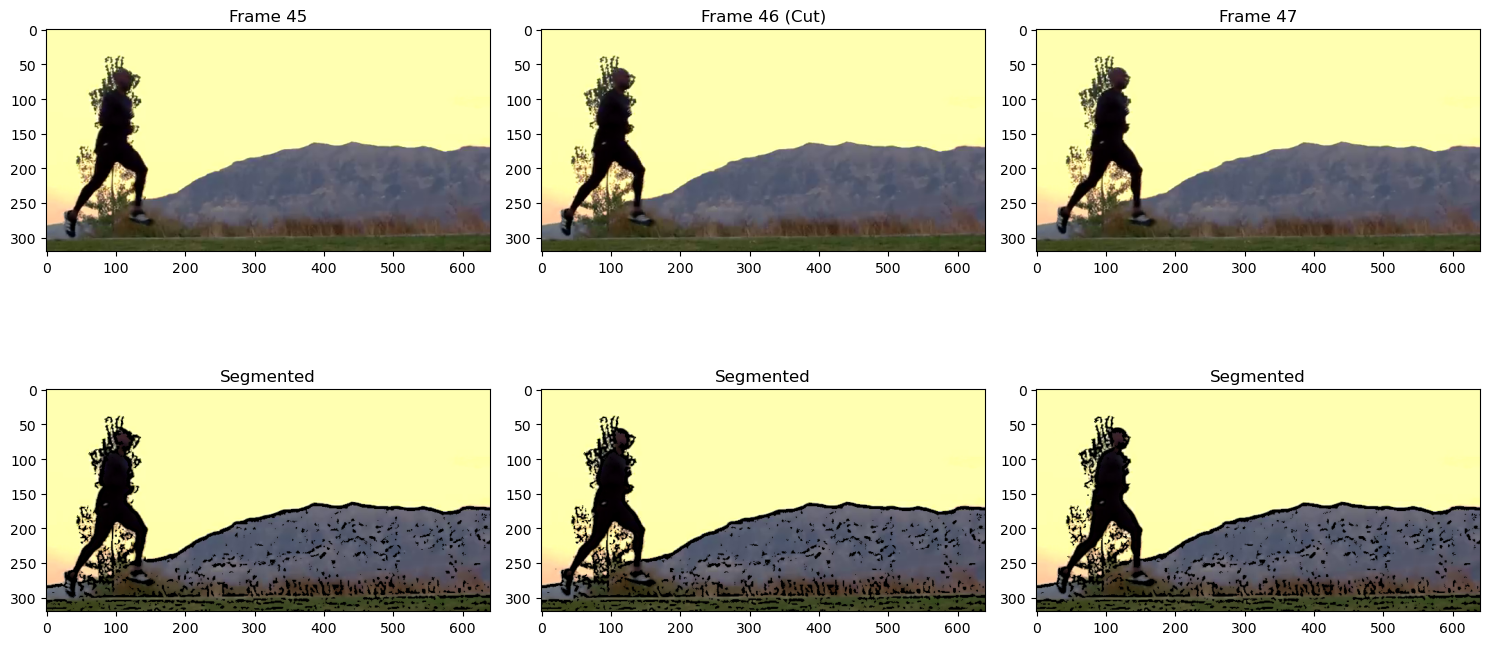

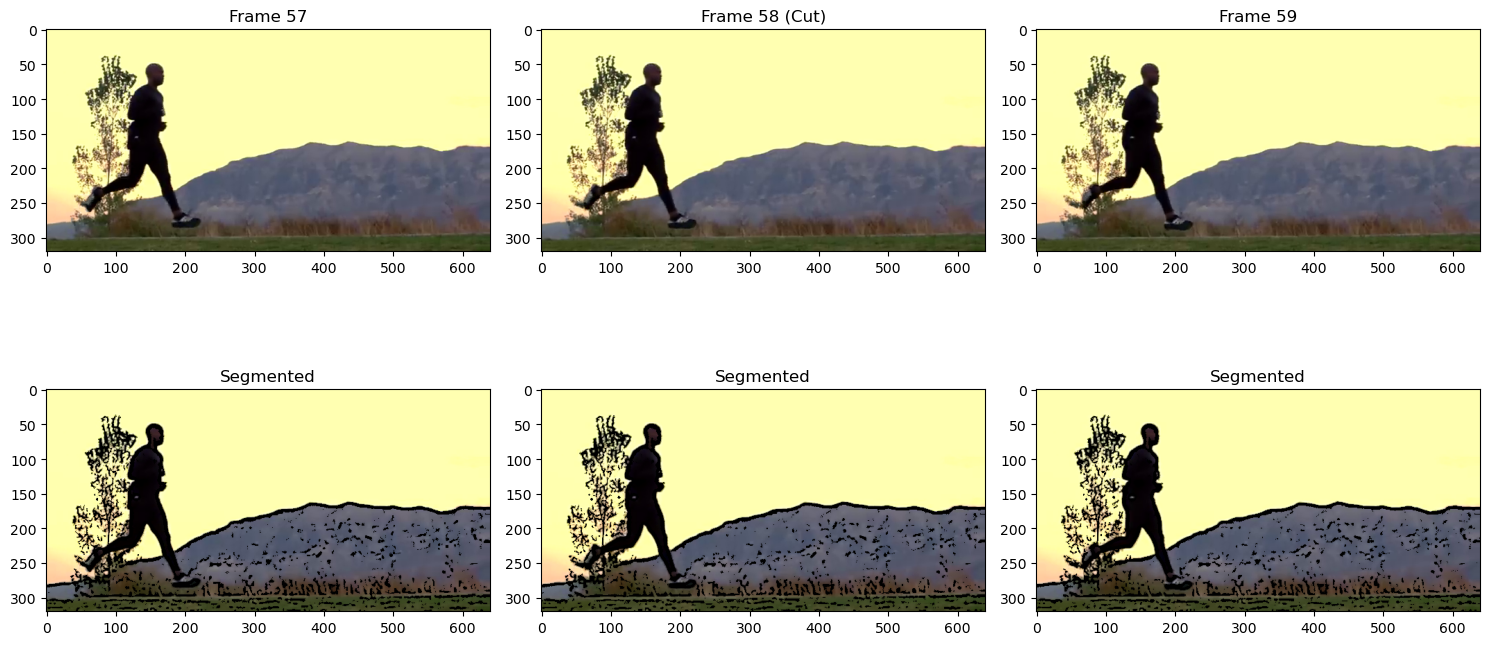

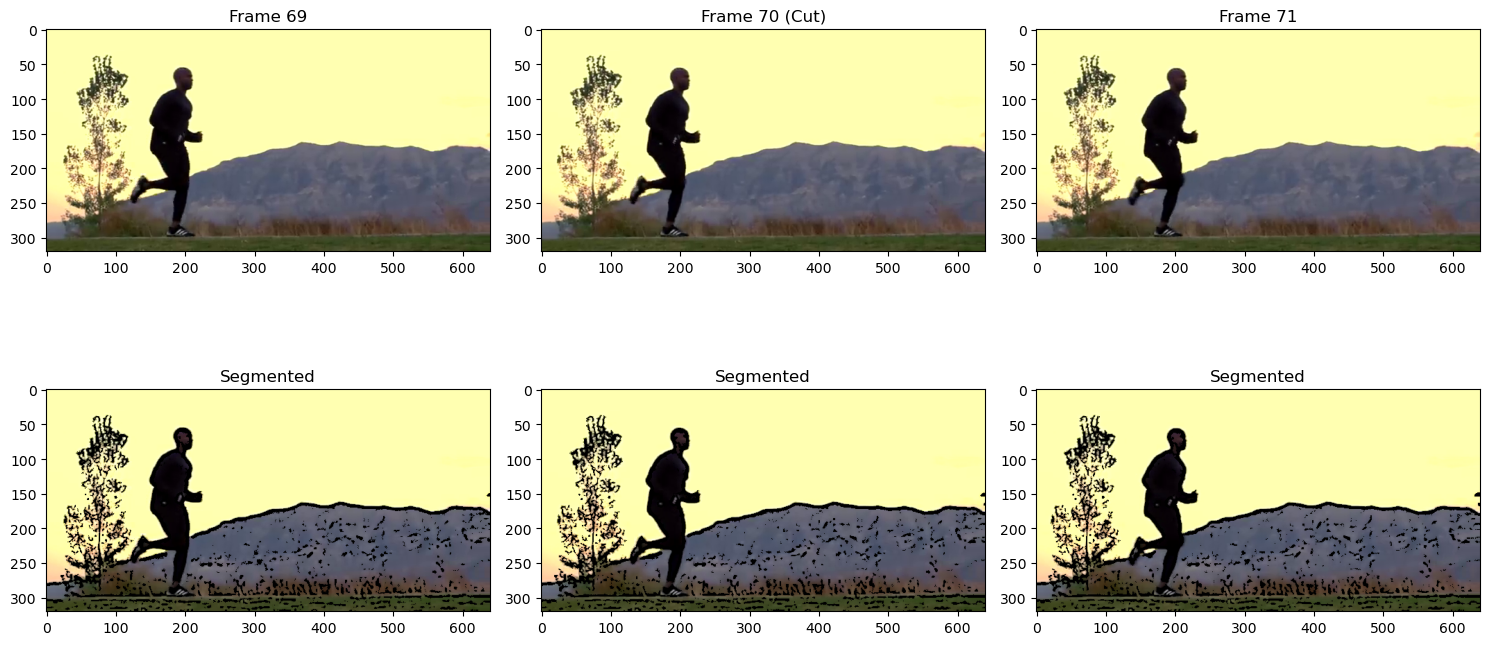

In [6]:
def visualize_results(frames, cut_indices, frame_differences, segmented_frames):

    plt.figure(figsize=(15, 5))
    plt.plot(frame_differences)
    plt.plot(cut_indices, [frame_differences[i] for i in cut_indices], 'ro')
    plt.title('Frame Differences with Detected Scene Cuts')
    plt.xlabel('Frame Number')
    plt.ylabel('Difference Score')
    plt.show()
    

    for cut_idx in cut_indices[:5]:  # Show first 5 cuts
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        

        axes[0,0].imshow(cv2.cvtColor(frames[cut_idx-1], cv2.COLOR_BGR2RGB))
        axes[0,0].set_title(f'Frame {cut_idx-1}')
        axes[0,1].imshow(cv2.cvtColor(frames[cut_idx], cv2.COLOR_BGR2RGB))
        axes[0,1].set_title(f'Frame {cut_idx} (Cut)')
        axes[0,2].imshow(cv2.cvtColor(frames[cut_idx+1], cv2.COLOR_BGR2RGB))
        axes[0,2].set_title(f'Frame {cut_idx+1}')
        

        axes[1,0].imshow(cv2.cvtColor(segmented_frames[cut_idx-1], cv2.COLOR_BGR2RGB))
        axes[1,0].set_title('Segmented')
        axes[1,1].imshow(cv2.cvtColor(segmented_frames[cut_idx], cv2.COLOR_BGR2RGB))
        axes[1,1].set_title('Segmented')
        axes[1,2].imshow(cv2.cvtColor(segmented_frames[cut_idx+1], cv2.COLOR_BGR2RGB))
        axes[1,2].set_title('Segmented')
        
        plt.tight_layout()
        plt.show()

visualize_results(frames, cut_indices, frame_differences, segmented_frames)


In [7]:
def save_results(frames, cut_indices, output_dir):

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    

    for i, cut_idx in enumerate(cut_indices):

        cv2.imwrite(
            str(output_dir / f'cut_{i}_before.jpg'), 
            frames[cut_idx-1]
        )
        cv2.imwrite(
            str(output_dir / f'cut_{i}_cut.jpg'), 
            frames[cut_idx]
        )
        cv2.imwrite(
            str(output_dir / f'cut_{i}_after.jpg'), 
            frames[cut_idx+1]
        )
    

    with open(output_dir / 'scene_cuts.txt', 'w') as f:
        f.write('Scene Cuts:\n')
        for i, cut_idx in enumerate(cut_indices):
            f.write(f'Cut {i}: Frame {cut_idx}\n')

output_dir = r"C:\Users\91936\Desktop\mvassignment3"
save_results(frames, cut_indices, output_dir)

In [8]:
cap.release()
cv2.destroyAllWindows()